#### This code file is a detailed procedure of demand forecasting for the given dataset 

## Loading the dataset 

In [1]:
import pandas as pd

# Path to the Excel file
excel_path = '/Users/abhishekroy/Downloads/vscode folder/online_retail_II 2.xlsx'  # Update this path as needed

# Load both sheets from the Excel file
sheet1 = pd.read_excel(excel_path, sheet_name=0)
sheet2 = pd.read_excel(excel_path, sheet_name=1)

# Combine the two sheets into one DataFrame
data = pd.concat([sheet1, sheet2], ignore_index=True)
data.describe()




,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


# PreProcessing pipeline

#### Removing Duplicates 

In [2]:
duplicates = data.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 34335


In [3]:
data.drop_duplicates(inplace=True)


#### Checking duplicates 

In [4]:
data.duplicated().sum()

0

### Clearing out the cancelled transactions since they might skew the actual demand 

In [5]:
# Filter out canceled transactions
data = data[~data['Invoice'].str.contains('C', na=False)]


In [6]:
# Display the initial number of rows for comparison
print("Initial number of rows:", data.shape[0])

# Remove rows where 'Quantity' or 'Price' is less than or equal to zero
data = data[data['Quantity'] > 0]
data = data[data['Price'] > 0]

# Display the number of rows after removing negative quantities and prices
print("Number of rows after removing negative quantities and prices:", data.shape[0])

# Optionally, check and display a few rows to confirm the cleaning
print(data.head())

Initial number of rows: 1013932
Number of rows after removing negative quantities and prices: 1007913
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [8]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Converting the dataframe into a datetime format for compatibility 

In [7]:
# Convert 'InvoiceDate' from string to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%d/%m/%y %H:%M')


In [8]:
# Replace missing 'Customer ID' values with a placeholder (-1)
data['Customer ID'].fillna(-1, inplace=True)

# # Drop rows where 'Description' is missing
# data = data.dropna(subset=['Description'])


/var/folders/rn/ys7gpqbn50jfhv2d8g6by0dm0000gn/T/ipykernel_12538/3049233262.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Customer ID'].fillna(-1, inplace=True)


## Visualisations 

### Checking for trends in the data 

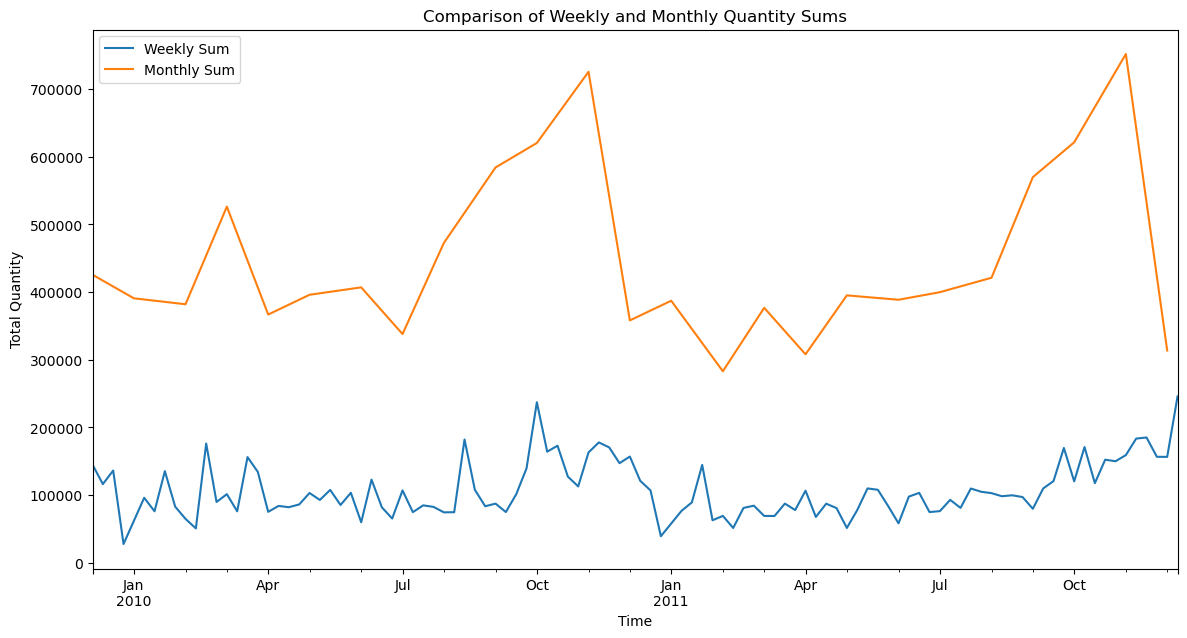

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is already loaded and 'InvoiceDate' is a datetime column
data['Week'] = data['InvoiceDate'].dt.to_period('W')
data['Month'] = data['InvoiceDate'].dt.to_period('M')

# Aggregating by Week and Month separately
weekly_sum = data.groupby('Week')['Quantity'].sum()
monthly_sum = data.groupby('Month')['Quantity'].sum()

# Plotting the results
plt.figure(figsize=(14, 7))
weekly_sum.plot(label='Weekly Sum')
monthly_sum.plot(label='Monthly Sum')
plt.legend()
plt.title('Comparison of Weekly and Monthly Quantity Sums')
plt.ylabel('Total Quantity')
plt.xlabel('Time')
plt.show()


# We can see that the trends repeat every year in december, hence we use a montlhy approach to create input sequence 

#### converting data into monthly data, by finding the sum of quantities, country wise and stockcode wise 

In [10]:
# Create a 'YearMonth' field for aggregation
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')

# Aggregate data at a monthly level per product per country
final_data = data.groupby([ 'YearMonth','Country', 'StockCode']).agg(Total_Quantity=('Quantity', 'sum')).reset_index()

# Display the aggregated data
print(final_data.head(40))


   YearMonth    Country StockCode  Total_Quantity
0    2009-12  Australia     20717              10
1    2009-12  Australia     20727              10
2    2009-12  Australia     20728              10
3    2009-12  Australia     20730              10
4    2009-12  Australia     21871              12
5    2009-12  Australia     21895               4
6    2009-12  Australia     21896               6
7    2009-12  Australia     22083              12
8    2009-12  Australia     22087              12
9    2009-12  Australia     22090              12
10   2009-12  Australia     22355              20
11   2009-12  Australia     84946              12
12   2009-12  Australia    84970S              24
13   2009-12  Australia    85206A               6
14   2009-12    Austria     20674              16
15   2009-12    Austria     20675              16
16   2009-12    Austria     20676              16
17   2009-12    Austria     20677              16
18   2009-12    Austria     20679              60


## Transforming the data for faster convergance 

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the Total_Quantity column and transform it
final_data['Total_Quantity_normalised'] = scaler.fit_transform(final_data[['Total_Quantity']])

# Display the first 40 rows of the dataframe to see the normalized Total_Quantity
print(final_data.head(40))


   YearMonth    Country StockCode  Total_Quantity  Total_Quantity_normalised
0    2009-12  Australia     20717              10                   0.000111
1    2009-12  Australia     20727              10                   0.000111
2    2009-12  Australia     20728              10                   0.000111
3    2009-12  Australia     20730              10                   0.000111
4    2009-12  Australia     21871              12                   0.000136
5    2009-12  Australia     21895               4                   0.000037
6    2009-12  Australia     21896               6                   0.000062
7    2009-12  Australia     22083              12                   0.000136
8    2009-12  Australia     22087              12                   0.000136
9    2009-12  Australia     22090              12                   0.000136
10   2009-12  Australia     22355              20                   0.000235
11   2009-12  Australia     84946              12                   0.000136

## Checking the range of monthly quantities 

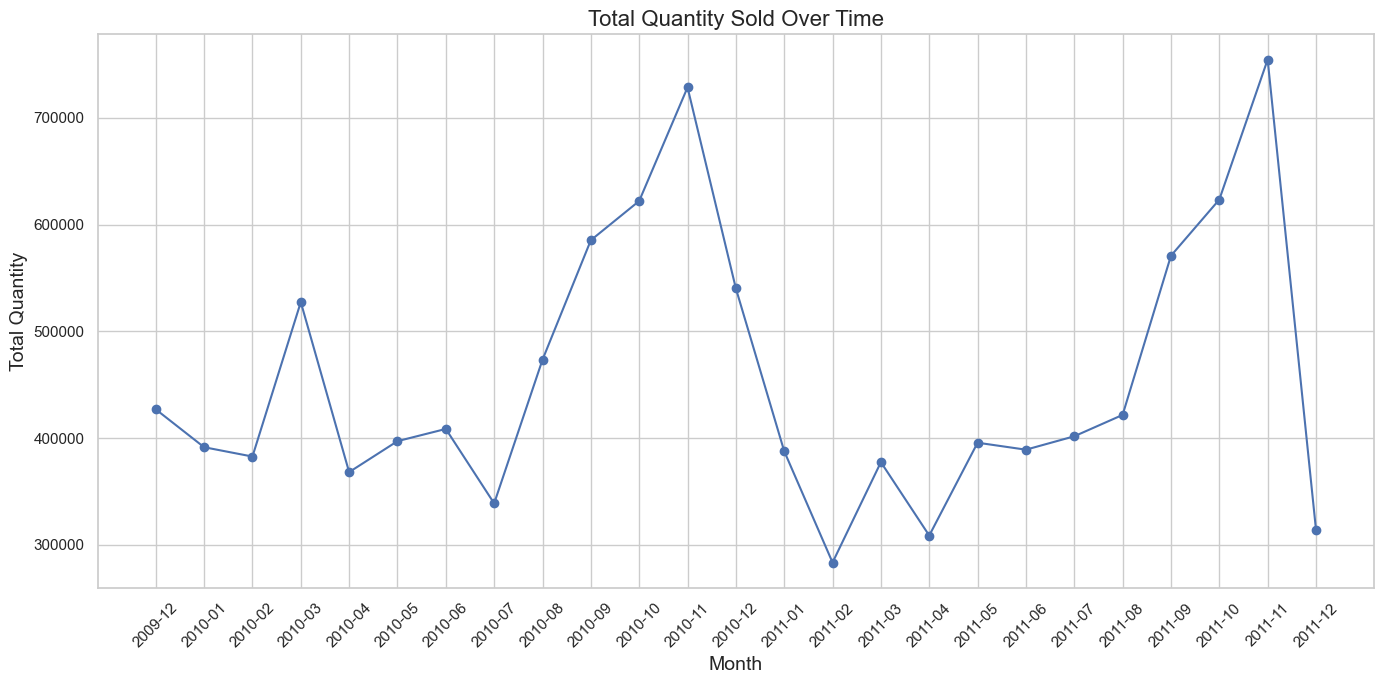

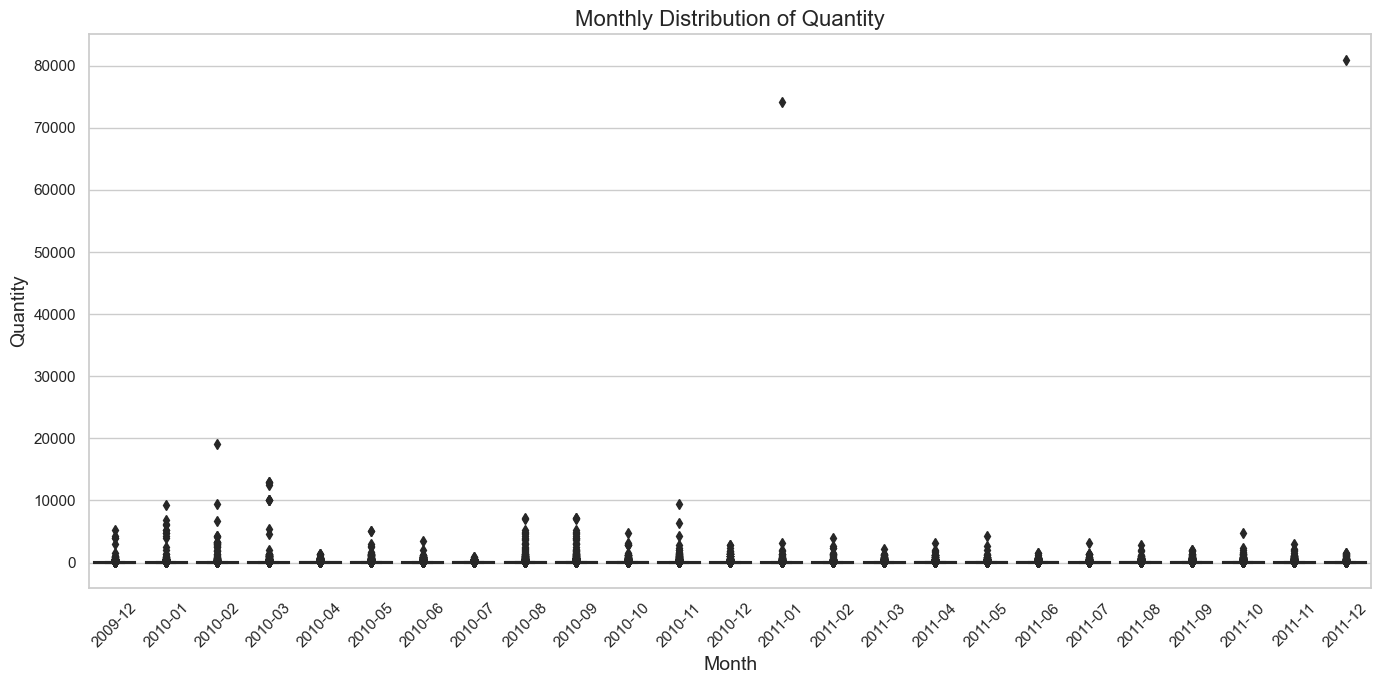

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame and 'YearMonth' field has been created for monthly aggregation

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Aggregate total quantity sold by month for plotting
monthly_quantity = data.groupby('YearMonth').agg(Total_Quantity=('Quantity', 'sum')).reset_index()

# Time Series Plot of Total Quantity Over Time
plt.figure(figsize=(14, 7))
plt.plot(monthly_quantity['YearMonth'].astype(str), monthly_quantity['Total_Quantity'], marker='o', linestyle='-', color='b')
plt.title('Total Quantity Sold Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Quantity', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Box Plot to visualize monthly distribution of Quantity
plt.figure(figsize=(14, 7))
sns.boxplot(x=data['YearMonth'].astype(str), y=data['Quantity'], palette="Blues")
plt.title('Monthly Distribution of Quantity', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/Users/abhishekroy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


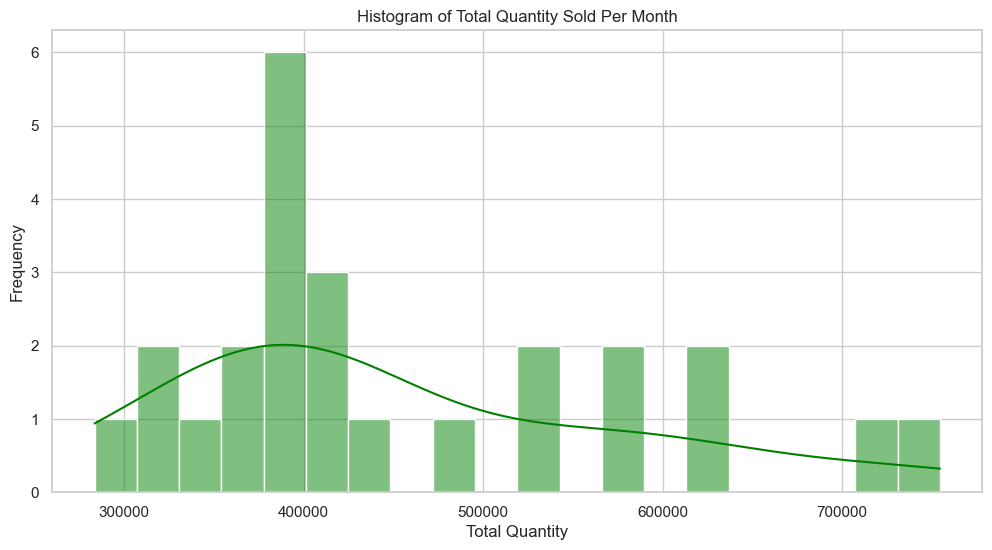

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')

# Aggregate total quantity sold by month
monthly_quantity = data.groupby('YearMonth').agg(Total_Quantity=('Quantity', 'sum')).reset_index()

# Histogram of Total Quantity Sold per Month
plt.figure(figsize=(12, 6))
sns.histplot(monthly_quantity['Total_Quantity'], bins=20, kde=True, color='green')
plt.title('Histogram of Total Quantity Sold Per Month')
plt.xlabel('Total Quantity')
plt.ylabel('Frequency')
plt.show()



## Checking for corelation between price and quantity purchased 

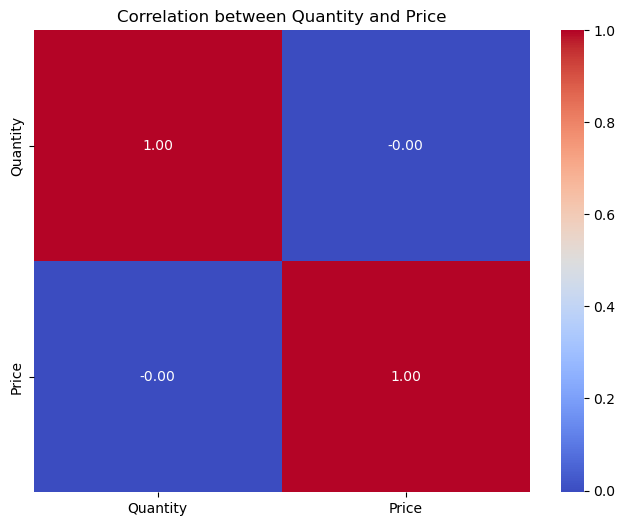

In [112]:
# Compute the correlation matrix for Quantity and Price
corr_matrix = data[['Quantity', 'Price']].corr()

# Generate a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Quantity and Price')
plt.show()

#### We don't see any corelation between price and quanity, hence we decide to use only quanity as a feature 

In [91]:
print(final_data.head(30))

   YearMonth    Country StockCode  Total_Quantity  Total_Quantity_normalised
0    2009-12  Australia     20717              10                   0.000111
1    2009-12  Australia     20727              10                   0.000111
2    2009-12  Australia     20728              10                   0.000111
3    2009-12  Australia     20730              10                   0.000111
4    2009-12  Australia     21871              12                   0.000136
5    2009-12  Australia     21895               4                   0.000037
6    2009-12  Australia     21896               6                   0.000062
7    2009-12  Australia     22083              12                   0.000136
8    2009-12  Australia     22087              12                   0.000136
9    2009-12  Australia     22090              12                   0.000136
10   2009-12  Australia     22355              20                   0.000235
11   2009-12  Australia     84946              12                   0.000136

## Grouping the normalised quanitities based on the type of stock and the country 

#### The chosen sequence length is 12 months since the trends repeat yearly 

In [13]:
# Organize data by Country, StockCode and sort by YearMonth to ensure correct sequence formation
grouped_data = final_data.sort_values(['Country', 'StockCode', 'YearMonth']).groupby(['Country', 'StockCode'])

# Define sequence length
sequence_length = 12

# Prepare input sequences (X) and labels (y)
X = []
y = []
country_stock_info = []  # to track which country and stock each sequence corresponds to

for (country_id, stock_id), group in grouped_data:
    if len(group) > sequence_length:
        for i in range(len(group) - sequence_length):
            sequence = group.iloc[i:i+sequence_length]['Total_Quantity_normalised'].values
            label = group.iloc[i+sequence_length]['Total_Quantity_normalised']
            X.append(sequence)
            y.append(label)
            country_stock_info.append((country_id, stock_id))  # Store country and stock information

# Convert lists to numpy arrays for model training
import numpy as np

X = np.array(X)
y = np.array(y)
country_stock_info = np.array(country_stock_info)  # Convert tracking info to numpy array for easier handling



In [15]:
X

array([[1.23465936e-05, 6.17329679e-05, 6.17329679e-05, ...,
        1.11119342e-04, 2.46931871e-05, 4.93863743e-05],
       [6.17329679e-05, 6.17329679e-05, 2.46931871e-05, ...,
        2.46931871e-05, 4.93863743e-05, 1.23465936e-05],
       [6.17329679e-05, 2.46931871e-05, 7.40795614e-05, ...,
        4.93863743e-05, 1.23465936e-05, 1.23465936e-05],
       ...,
       [0.00000000e+00, 1.23465936e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.23465936e-05],
       [1.23465936e-05, 0.00000000e+00, 2.46931871e-05, ...,
        0.00000000e+00, 1.23465936e-05, 0.00000000e+00],
       [0.00000000e+00, 2.46931871e-05, 2.46931871e-05, ...,
        1.23465936e-05, 0.00000000e+00, 1.23465936e-05]])

In [16]:
X.shape

(24133, 12)

## Creating a test train split

In [33]:
from sklearn.model_selection import train_test_split



# First, split the data into a training set and a temporary test set
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Then split the temporary test set into validation and actual test sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=0)  # 0.25 x 0.8 = 0.2


# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [23]:
X_train

array([[[9.16117243e-03],
        [4.14845544e-03],
        [1.05192977e-02],
        ...,
        [9.30933156e-03],
        [3.40765983e-03],
        [5.80289898e-03]],

       [[9.01301331e-03],
        [7.71662098e-03],
        [7.54376867e-03],
        ...,
        [1.13588661e-02],
        [4.32130775e-03],
        [4.49416006e-03]],

       [[5.80289898e-04],
        [6.17329679e-05],
        [6.17329679e-05],
        ...,
        [6.17329679e-05],
        [5.06210337e-04],
        [6.17329679e-05]],

       ...,

       [[0.00000000e+00],
        [9.87727486e-05],
        [1.48159123e-04],
        ...,
        [3.45704620e-04],
        [1.97545497e-04],
        [1.23465936e-05]],

       [[1.20996617e-03],
        [3.39531323e-03],
        [2.75329037e-03],
        ...,
        [1.24700595e-03],
        [6.79062647e-04],
        [1.24700595e-03]],

       [[2.32115959e-03],
        [4.14845544e-03],
        [7.77835395e-03],
        ...,
        [9.25994518e-04],
        [2.3458

### Naive model 

Epoch 1/50
453/453 [==============================] - 4s 6ms/step - loss: 1.2383e-05 - mae: 0.0014 - val_loss: 8.1155e-06 - val_mae: 0.0012
Epoch 2/50
453/453 [==============================] - 3s 6ms/step - loss: 1.1838e-05 - mae: 0.0014 - val_loss: 7.9197e-06 - val_mae: 0.0013
Epoch 3/50
453/453 [==============================] - 3s 6ms/step - loss: 1.1679e-05 - mae: 0.0014 - val_loss: 8.0813e-06 - val_mae: 0.0016
Epoch 4/50
453/453 [==============================] - 2s 5ms/step - loss: 1.1605e-05 - mae: 0.0014 - val_loss: 7.7757e-06 - val_mae: 0.0013
Epoch 5/50
453/453 [==============================] - 2s 5ms/step - loss: 1.1525e-05 - mae: 0.0014 - val_loss: 9.1103e-06 - val_mae: 0.0021
Epoch 6/50
453/453 [==============================] - 3s 6ms/step - loss: 1.1481e-05 - mae: 0.0014 - val_loss: 7.6691e-06 - val_mae: 0.0013
Epoch 7/50
453/453 [==============================] - 2s 5ms/step - loss: 1.1447e-05 - mae: 0.0014 - val_loss: 7.6359e-06 - val_mae: 0.0013
Epoch 8/50
453/453 [

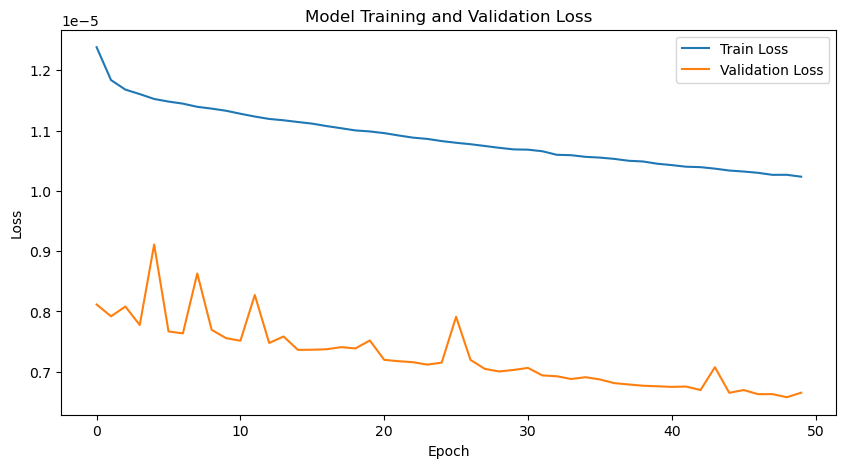

151/151 [==============================] - 0s 3ms/step - loss: 6.6523e-06 - mae: 0.0013
Test Loss: [6.652347565250238e-06, 0.0013259693514555693]


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

# Define the LSTM model architecture
model = Sequential([
    LSTM(8, activation='relu', input_shape=(X_train.shape[1], 1)),  # LSTM layer with 50 units
    Dense(1)  # Output layer to predict sales quantity
])
# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mse',metrics=['mae'])
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)


### Since the input features were normalised, we have to inverse the transformation to see the actual perfromace 

In [16]:

min_data = final_data['Total_Quantity'].min()
max_data = final_data['Total_Quantity'].max()

# Example normalized errors (let's assume you have these values calculated)
norm_mae = 0.0015751826576888561 # Example normalized MAE
norm_mse = 1.224065817950759e-05 # Example normalized RMSE

# Calculating the original scale MAE and RMSE
original_mae = norm_mae * (max_data - min_data)
original_rmse = norm_mse * (max_data - min_data)

print(f"Original MAE: {original_mae}")
print(f"Original RMSE: {original_rmse}")



Original MAE: 127.58034417685121
Original RMSE: 0.9914198685910378


## Trying to beat the baseline model 

Epoch 1/40
29/29 [==============================] - 7s 96ms/step - loss: 1.4965e-05 - mae: 0.0018 - val_loss: 2.2679e-05 - val_mae: 0.0016
Epoch 2/40
29/29 [==============================] - 2s 78ms/step - loss: 1.3826e-05 - mae: 0.0016 - val_loss: 2.1329e-05 - val_mae: 0.0016
Epoch 3/40
29/29 [==============================] - 2s 84ms/step - loss: 1.3089e-05 - mae: 0.0016 - val_loss: 2.0628e-05 - val_mae: 0.0018
Epoch 4/40
29/29 [==============================] - 2s 83ms/step - loss: 1.2724e-05 - mae: 0.0016 - val_loss: 2.0119e-05 - val_mae: 0.0016
Epoch 5/40
29/29 [==============================] - 3s 87ms/step - loss: 1.2289e-05 - mae: 0.0016 - val_loss: 1.9585e-05 - val_mae: 0.0015
Epoch 6/40
29/29 [==============================] - 2s 82ms/step - loss: 1.1808e-05 - mae: 0.0015 - val_loss: 1.8953e-05 - val_mae: 0.0015
Epoch 7/40
29/29 [==============================] - 2s 86ms/step - loss: 1.1383e-05 - mae: 0.0015 - val_loss: 1.8428e-05 - val_mae: 0.0014
Epoch 8/40
29/29 [=========

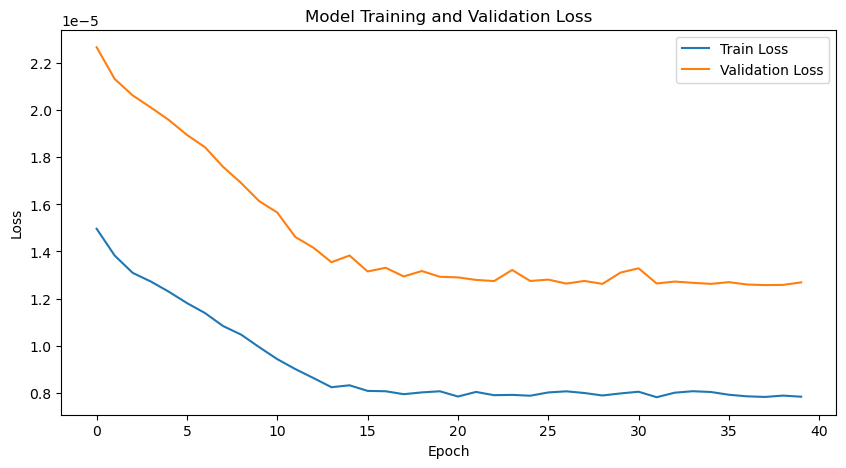

151/151 [==============================] - 1s 6ms/step - loss: 1.2687e-05 - mae: 0.0011
Test Loss: [1.26868617371656e-05, 0.0010591711616143584]


In [25]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(32, activation='relu',return_sequences=True),
    Dropout(0.3),
    LSTM(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse',metrics=['mae'])
# Train the model
history = model.fit(X_train, y_train, epochs=40,batch_size=512, validation_data=(X_test, y_test), verbose=1)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)


### Inverse transforming the test loss to see actual performance 

In [26]:

min_data = final_data['Total_Quantity'].min()
max_data = final_data['Total_Quantity'].max()

# Example normalized errors (let's assume you have these values calculated)
norm_mae =0.0010591711616143584 # Example normalized MAE
norm_mse = 1.26868617371656e-05 # Example normalized RMSE

# Calculating the original scale MAE and RMSE
original_mae = norm_mae * (max_data - min_data)
original_rmse = norm_mse * (max_data - min_data)*(max_data - min_data)

print(f"Original MAE: {original_mae}")
print(f"Original MSE: {original_rmse}")



Original MAE: 85.78650906379335
Original MSE: 83226.168684662


### Incorporating Early stopping to prevent overfittig

Epoch 1/100
29/29 [==============================] - 8s 97ms/step - loss: 1.4456e-05 - mae: 0.0018 - val_loss: 1.7364e-05 - val_mae: 0.0020
Epoch 2/100
29/29 [==============================] - 3s 87ms/step - loss: 1.3402e-05 - mae: 0.0017 - val_loss: 1.6804e-05 - val_mae: 0.0019
Epoch 3/100
29/29 [==============================] - 2s 84ms/step - loss: 1.3052e-05 - mae: 0.0017 - val_loss: 1.6583e-05 - val_mae: 0.0016
Epoch 4/100
29/29 [==============================] - 2s 79ms/step - loss: 1.2849e-05 - mae: 0.0017 - val_loss: 1.6197e-05 - val_mae: 0.0017
Epoch 5/100
29/29 [==============================] - 2s 82ms/step - loss: 1.2528e-05 - mae: 0.0017 - val_loss: 1.5855e-05 - val_mae: 0.0017
Epoch 6/100
29/29 [==============================] - 2s 79ms/step - loss: 1.2213e-05 - mae: 0.0016 - val_loss: 1.5512e-05 - val_mae: 0.0016
Epoch 7/100
29/29 [==============================] - 3s 92ms/step - loss: 1.2007e-05 - mae: 0.0016 - val_loss: 1.5089e-05 - val_mae: 0.0017
Epoch 8/100
29/29 [=

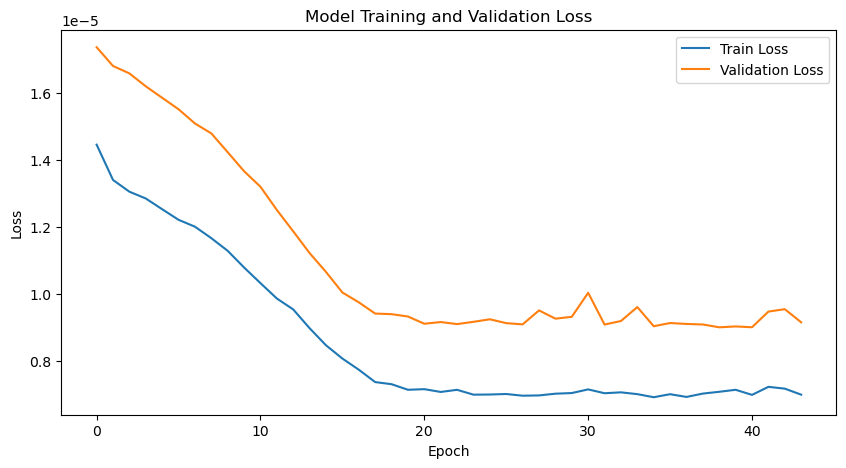

151/151 [==============================] - 1s 4ms/step - loss: 9.0043e-06 - mae: 0.0011
Test Loss: [9.004304047266487e-06, 0.0011274340795353055]


In [34]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Setup early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train, 
    epochs=100,
    batch_size=512, 
    validation_data=(X_test, y_test), 
    verbose=1,
    callbacks=[early_stopping]  # Add early stopping to callbacks
)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)


### Inverse transforming the test loss to get actual values 

In [36]:

min_data = final_data['Total_Quantity'].min()
max_data = final_data['Total_Quantity'].max()

# Example normalized errors (let's assume you have these values calculated)
norm_mae =0.00104 # Example normalized MAE
norm_mse = 9.004304047266487e-06 # Example normalized RMSE

# Calculating the original scale MAE and RMSE
original_mae = norm_mae * (max_data - min_data)
original_rmse = norm_mse * (max_data - min_data)*(max_data - min_data)

print(f"Original MAE: {original_mae}")
print(f"Original MSE: {original_rmse}")



Original MAE: 84.23375999999999
Original MSE: 59068.48699473642


#### We were able to sucesfully beat the naive model 

## Forecasting on the dataset 

##### This Snippet runs for quite a long time ie 10-12 mins 

In [38]:
import pandas as pd
import numpy as np


# Ensure the model is already in memory

# Calculate min and max for inverse normalization
min_data = final_data['Total_Quantity'].min()
max_data = final_data['Total_Quantity'].max()

# Get unique combinations of Country and StockCode
unique_combinations = final_data[['Country', 'StockCode']].drop_duplicates()

# Prepare a list to store the predictions
predictions = []

# Iterate over each combination
for _, row in unique_combinations.iterrows():
    country = row['Country']
    stock_code = row['StockCode']
    
    # Filter data for the specific country and stock code
    filtered_data = final_data[(final_data['Country'] == country) & (final_data['StockCode'] == stock_code)]
    
    # Ensure the data is sorted by YearMonth
    filtered_data = filtered_data.sort_values('YearMonth')

    # Check if there are enough data points for the last sequence
    sequence_length = 12 # This is your model's expected sequence length
    if len(filtered_data) >= sequence_length:
        # Prepare the last sequence using the normalized quantity
        last_sequence = filtered_data[-sequence_length:]['Total_Quantity_normalised'].values.reshape(1, sequence_length, 1)  # Reshape for LSTM input

        # Make prediction using the model already in memory
        predicted_normalized_quantity = model.predict(last_sequence)
        predicted_normalized_quantity = predicted_normalized_quantity[0][0]

        # Inverse normalization
        predicted_quantity = (predicted_normalized_quantity * (max_data - min_data)) + min_data
    else:
        predicted_quantity = None  # Indicate insufficient data for prediction

    # Append the result to the list
    predictions.append({
        'Country': country,
        'StockCode': stock_code,
        'Predicted_Quantity': predicted_quantity  # Saving the actual predicted quantity
    })

# Convert the list of dictionaries to a DataFrame
predictions_df = pd.DataFrame(predictions)

# Now you have a DataFrame with all predictions
print(predictions_df.head())

# Optionally, save the DataFrame to a CSV file
predictions_df.to_csv('predicted_actual_quantities.csv', index=False)


1/1 [==============================] - 0s 20ms/step
     Country StockCode  Predicted_Quantity
0  Australia     20717                 NaN
1  Australia     20727                 NaN
2  Australia     20728                 NaN
3  Australia     20730                 NaN
4  Australia     21871                 NaN


### Some of the values in the predicted dataset are missing because the dataset, did not contain a sequence length of 12 for those entries, This issue can be fixed by reducing the sequence length, although if that is done the model will not be able to capture the trend completely that repeats yearly

In [40]:
# Filter the DataFrame to exclude rows where Predicted_Quantity is NaN
non_nan_predictions = predictions_df.dropna(subset=['Predicted_Quantity'])

# Display the first 30 entries of the filtered DataFrame
print(non_nan_predictions.head(30))


     Country StockCode  Predicted_Quantity
51   Austria      POST           28.795476
53   Belgium     21212           49.446954
66   Belgium     22355           34.607052
70   Belgium      POST           34.386509
293  Denmark      POST           28.541036
297     EIRE     20679           30.161211
300     EIRE     20685           45.399608
302     EIRE     20725           61.774212
303     EIRE     20728           50.367718
307     EIRE     20749           28.893999
309     EIRE     20751           41.195233
312     EIRE     20754           59.784742
314     EIRE     20828           31.047796
318     EIRE     20914           92.210763
321     EIRE     20979           62.215920
332     EIRE     21156           31.667956
334     EIRE     21164           57.701521
336     EIRE     21175           44.554313
337     EIRE     21181          102.324643
339     EIRE     21210           69.285477
340     EIRE     21212          128.645743
343     EIRE     21231           38.715478
344     EIR